In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import PIL
import pathlib
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Dropout, Flatten,Activation, BatchNormalization,MaxPooling2D
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import shutil
from random import sample, choices
import hashlib
from PIL import Image, ImageEnhance
import torch
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader, Dataset

In [14]:
path = pathlib.Path("./Raw-Dataset")

In [15]:
pakistani = list(path.glob('Pakistani cuisine/*'))

In [16]:
pakistani[:10]

[PosixPath('Raw-Dataset/Pakistani cuisine/brownie6.jpg'),
 PosixPath('Raw-Dataset/Pakistani cuisine/biryani4.jpg'),
 PosixPath('Raw-Dataset/Pakistani cuisine/bbq4.jpg'),
 PosixPath('Raw-Dataset/Pakistani cuisine/brownie7.jpg'),
 PosixPath('Raw-Dataset/Pakistani cuisine/brownie5.jpg'),
 PosixPath('Raw-Dataset/Pakistani cuisine/biryani2.jpg'),
 PosixPath('Raw-Dataset/Pakistani cuisine/bbq2.jpg'),
 PosixPath('Raw-Dataset/Pakistani cuisine/.DS_Store'),
 PosixPath('Raw-Dataset/Pakistani cuisine/bbq3.jpg'),
 PosixPath('Raw-Dataset/Pakistani cuisine/biryani3.jpg')]

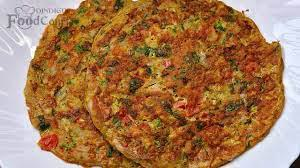

In [17]:
PIL.Image.open(str(pakistani[23]))

# Stats of the Dataset

In [18]:
main_images_folder = "./Raw-Dataset"
image_stats = {}
for folder in os.listdir(main_images_folder):
    folder_path = os.path.join(main_images_folder, folder)
    if os.path.isdir(folder_path):
        images = os.listdir(folder_path)
        image_stats[folder] = {
            "num_images": len(images),
            "dimensions": []
        }
        for image_file in images:
            image_path = os.path.join(folder_path, image_file)
            try:
                with Image.open(image_path) as img:
                    image_stats[folder]["dimensions"].append(img.size)
            except:
                pass
stats_summary = pd.DataFrame({
    "Cuisine Class": image_stats.keys(),
    "Number of Images": [value["num_images"] for value in image_stats.values()],
    "Sample Dimensions": [value["dimensions"][0] if value["dimensions"] else None for value in image_stats.values()]
})
print(stats_summary)

       Cuisine Class  Number of Images Sample Dimensions
0   Japanese cuisine                64      (1599, 1199)
1     Indian cuisine                75      (3000, 2000)
2    Chinese cuisine                59      (2000, 3000)
3  Pakistani cuisine                60        (680, 978)
4    Italian cuisine                72      (6016, 4000)


# Balancing the Dataset

In [19]:
main_images_folder = "./Raw-Dataset"
balanced_folder = "./balanced_images"
class_counts = {folder: len(os.listdir(os.path.join(main_images_folder, folder)))
                for folder in os.listdir(main_images_folder)
                if os.path.isdir(os.path.join(main_images_folder, folder))}
min_class_size = min(class_counts.values())
os.makedirs(balanced_folder, exist_ok=True)
for folder in class_counts.keys():
    folder_path = os.path.join(main_images_folder, folder)
    balanced_class_path = os.path.join(balanced_folder, folder)
    os.makedirs(balanced_class_path, exist_ok=True)
    all_images = os.listdir(folder_path)
    sampled_images = sample(all_images, min_class_size)
    for image in sampled_images:
        src_path = os.path.join(folder_path, image)
        dst_path = os.path.join(balanced_class_path, image)
        shutil.copy(src_path, dst_path)
print(f"Dataset balanced with {min_class_size} images per class. Balanced dataset saved in {balanced_folder}.")

Dataset balanced with 59 images per class. Balanced dataset saved in ./balanced_images.


# Remove Duplicates

In [20]:
balanced_folder = "./balanced_images"
def calculate_image_hash(image_path):
    try:
        with Image.open(image_path) as img:
            img = img.convert("RGB")
            return hashlib.md5(img.tobytes()).hexdigest()
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None
hashes = {}
for folder in os.listdir(balanced_folder):
    folder_path = os.path.join(balanced_folder, folder)
    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            file_hash = calculate_image_hash(file_path)
            if file_hash:
                if file_hash in hashes:
                    os.remove(file_path)
                    print(f"Removed duplicate: {file_path}")
                else:
                    hashes[file_hash] = file_path
print("Duplicate removal completed.")

Removed duplicate: ./balanced_images/Japanese cuisine/Image_32.jpg
Removed duplicate: ./balanced_images/Indian cuisine/Image_30.jpeg
Removed duplicate: ./balanced_images/Chinese cuisine/Image_7.JPG
Error processing image ./balanced_images/Pakistani cuisine/.DS_Store: cannot identify image file './balanced_images/Pakistani cuisine/.DS_Store'
Duplicate removal completed.


# Balancing the unique Dataset

In [21]:
main_images_folder = "./balanced_images"
balanced_folder = "./balanced_unique_images"
class_counts = {folder: len(os.listdir(os.path.join(main_images_folder, folder)))
                for folder in os.listdir(main_images_folder)
                if os.path.isdir(os.path.join(main_images_folder, folder))}
min_class_size = min(class_counts.values())
os.makedirs(balanced_folder, exist_ok=True)
for folder in class_counts.keys():
    folder_path = os.path.join(main_images_folder, folder)
    balanced_class_path = os.path.join(balanced_folder, folder)
    os.makedirs(balanced_class_path, exist_ok=True)
    all_images = os.listdir(folder_path)
    sampled_images = sample(all_images, min_class_size)
    for image in sampled_images:
        src_path = os.path.join(folder_path, image)
        dst_path = os.path.join(balanced_class_path, image)
        shutil.copy(src_path, dst_path)
print(f"Dataset balanced with {min_class_size} images per class. Balanced dataset saved in {balanced_folder}.")

Dataset balanced with 58 images per class. Balanced dataset saved in ./balanced_unique_images.


# Resizing the images to 224x224

In [22]:
balanced_folder = "./balanced_images"
resized_folder = "./resized_images"
os.makedirs(resized_folder, exist_ok=True)
resize_to = (224, 224)
for folder in os.listdir(balanced_folder):
    folder_path = os.path.join(balanced_folder, folder)
    resized_class_folder = os.path.join(resized_folder, folder)
    os.makedirs(resized_class_folder, exist_ok=True)
    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path):
            src_path = os.path.join(folder_path, file_name)
            dest_path = os.path.join(resized_class_folder, file_name)
            
            try:
                with Image.open(src_path) as img:
                    img = img.resize(resize_to, Image.ANTIALIAS)
                    img.save(dest_path)
            except Exception as e:
                print(f"Error processing {src_path}: {e}")
print(f"All images resized to {resize_to} and saved in {resized_folder}.")

/var/folders/bh/phg5j6rx557fc31zr9pgztnr0000gn/T/ipykernel_26077/1732796693.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize(resize_to, Image.ANTIALIAS)


Error processing ./balanced_images/Japanese cuisine/sashimi_fish_food_seafood_japanese_vegetables_raw_fresh-893160.jpg!d: unknown file extension: .jpg!d
Error processing ./balanced_images/Pakistani cuisine/.DS_Store: cannot identify image file './balanced_images/Pakistani cuisine/.DS_Store'
All images resized to (224, 224) and saved in ./resized_images.


# Enhancing the Dataset

In [23]:
resized_folder = "./resized_images"
cleaned_folder = "./Processed-Dataset"
os.makedirs(cleaned_folder, exist_ok=True)
quality_threshold = 100

def calculate_sharpness(image_path):
    """Calculate sharpness using variance of Laplacian."""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return 0
    return cv2.Laplacian(image, cv2.CV_64F).var()

def enhance_image(image_path, output_path):
    """Try to enhance the quality of a low-quality image."""
    try:
        with Image.open(image_path) as img:
            enhancer = ImageEnhance.Sharpness(img)
            img = enhancer.enhance(2.0)
            enhancer = ImageEnhance.Brightness(img)
            img = enhancer.enhance(1.2)
            img.save(output_path)
    except Exception as e:
        print(f"Error enhancing image {image_path}: {e}")
        return False
    return True
for folder in os.listdir(resized_folder):
    folder_path = os.path.join(resized_folder, folder)
    cleaned_class_folder = os.path.join(cleaned_folder, folder)
    os.makedirs(cleaned_class_folder, exist_ok=True)
    
    for file_name in os.listdir(folder_path):
        src_path = os.path.join(folder_path, file_name)
        dest_path = os.path.join(cleaned_class_folder, file_name)
        
        sharpness = calculate_sharpness(src_path)
        
        if sharpness >= quality_threshold:
            shutil.copy(src_path, dest_path)
        else:
            enhanced_success = enhance_image(src_path, dest_path)
            if enhanced_success:
                new_sharpness = calculate_sharpness(dest_path)
                if new_sharpness < quality_threshold:
                    os.remove(dest_path)
            else:
                print(f"Low-quality image removed: {src_path}")
print(f"Dataset cleaned. High-quality images saved in {cleaned_folder}.")

Error enhancing image ./resized_images/Japanese cuisine/Image_5.gif: cannot filter palette images
Low-quality image removed: ./resized_images/Japanese cuisine/Image_5.gif
Dataset cleaned. High-quality images saved in ./Processed-Dataset.


# Labeling the Dataset

In [24]:
cleaned_folder = "./Processed-Dataset"
data_labels = []
for label, folder in enumerate(os.listdir(cleaned_folder)):
    folder_path = os.path.join(cleaned_folder, folder)
    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            data_labels.append({"file_path": file_path, "class_name": folder, "label": label})
df_labels = pd.DataFrame(data_labels)
output_csv = "./dataset_labels.csv"
df_labels.to_csv(output_csv, index=False)
print(f"Labels saved to {output_csv}")

Labels saved to ./dataset_labels.csv


In [25]:
cleaned_folder = "./Processed-Dataset"
train_folder = "./Processed-Dataset/train"
test_folder = "./Processed-Dataset/test"
csv_file = "./dataset_labels.csv"

In [26]:
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

In [27]:
df = pd.read_csv(csv_file)

In [28]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["class_name"], random_state=42)

In [29]:
for _, row in train_df.iterrows():
    src = row["file_path"]
    dest = os.path.join(train_folder, row["class_name"])  # Keep class structure
    os.makedirs(dest, exist_ok=True)
    shutil.copy(src, os.path.join(dest, os.path.basename(src)))

In [30]:
for _, row in test_df.iterrows():
    src = row["file_path"]
    dest = os.path.join(test_folder, row["class_name"])  # Keep class structure
    os.makedirs(dest, exist_ok=True)
    shutil.copy(src, os.path.join(dest, os.path.basename(src)))

In [31]:
train_df.to_csv("./Processed-Dataset/train_labels.csv", index=False)
test_df.to_csv("./Processed-Dataset/test_labels.csv", index=False)

In [32]:
print(f"Training data saved: {len(train_df)} images → {train_folder}")
print(f"Testing data saved: {len(test_df)} images → {test_folder}")

Training data saved: 231 images → ./Processed-Dataset/train
Testing data saved: 58 images → ./Processed-Dataset/test


# Model

In [33]:
DATASET_PATH = "Processed-Dataset/"

In [34]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

Found 564 files belonging to 7 classes.
Using 452 files for training.


In [35]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

Found 564 files belonging to 7 classes.
Using 112 files for validation.


In [36]:
class_names = train_ds.class_names
print("Classes:", class_names)

Classes: ['Chinese cuisine', 'Indian cuisine', 'Italian cuisine', 'Japanese cuisine', 'Pakistani cuisine', 'test', 'train']


In [37]:
AUTOTUNE = tf.data.AUTOTUNE

In [38]:
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [39]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')

In [40]:
base_model.trainable = False

In [41]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(class_names), activation='softmax')  # Output layer for classes
])

In [42]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [43]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [44]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 661ms/step - accuracy: 0.2828 - loss: 2.1582 - val_accuracy: 0.4286 - val_loss: 1.8333
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 591ms/step - accuracy: 0.3900 - loss: 1.8095 - val_accuracy: 0.3482 - val_loss: 1.7870
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 586ms/step - accuracy: 0.3942 - loss: 1.7289 - val_accuracy: 0.4286 - val_loss: 1.7652
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 601ms/step - accuracy: 0.4176 - loss: 1.6572 - val_accuracy: 0.4286 - val_loss: 1.7560
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 629ms/step - accuracy: 0.4091 - loss: 1.6360 - val_accuracy: 0.3750 - val_loss: 1.8189
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 630ms/step - accuracy: 0.3778 - loss: 1.6322 - val_accuracy: 0.4107 - val_loss: 1.7971
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 639ms/step - accuracy: 0.3954 - loss: 1.5480 - val_accuracy: 0.3571 - val_loss: 1.8296
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 637ms/step - accuracy: 0.4001 - loss: 1.5990 - val_accuracy

In [45]:
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_acc:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 408ms/step - accuracy: 0.3397 - loss: 1.9276
Validation Accuracy: 0.3571
